# Cantilever with a Tip Moment

This example shows how to predict the behavior of a cantilever beam that is subjected
to a constant tip moment.  This is a common benchmark problem for the geometrically
nonlinear analysis of beams.

![](../assets/tipmoment-drawing.svg)

In [1]:
using GXBeam, LinearAlgebra

L = 12 # inches
h = w = 1 # inches
E = 30e6 # lb/in^4 Young's Modulus

A = h*w
Iyy = w*h^3/12
Izz = w^3*h/12

# bending moment (applied at end)
λ = [0.0, 0.4, 0.8, 1.2, 1.6, 1.8, 2.0]
m = pi*E*Iyy/L
M = λ*m

# create points
nelem = 16
x = range(0, L, length=nelem+1)
y = zero(x)
z = zero(x)
points = [[x[i],y[i],z[i]] for i = 1:length(x)]

# index of endpoints of each beam element
start = 1:nelem
stop = 2:nelem+1

# compliance matrix for each beam element
compliance = fill(Diagonal([1/(E*A), 0, 0, 0, 1/(E*Iyy), 1/(E*Izz)]), nelem)

# create assembly of interconnected nonlinear beams
assembly = Assembly(points, start, stop, compliance=compliance)

# pre-initialize system storage
system = StaticSystem(assembly)

# run an analysis for each prescribed bending moment
states = Vector{AssemblyState{Float64}}(undef, length(M))
for i = 1:length(M)

    # create dictionary of prescribed conditions
    prescribed_conditions = Dict(
        # fixed left side
        1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0, theta_z=0),
        # moment on right side
        nelem+1 => PrescribedConditions(Mz = M[i])
    )

    # perform a static analysis
    _, states[i], converged = static_analysis!(system, assembly;
        prescribed_conditions = prescribed_conditions)

end

nothing #hide

## Comparison with Analytical Results

This problem has a simple analytical solution, which we obtained from "Study of the
Geometric Stiffening Effect: Comparison of Different Formulations" by Juana M. Mayo,
Daniel Garcia-Vallejo, and Jaime Dominguez.

In [2]:
# analytical solution (ρ = E*I/M)
analytical(x, ρ) = ifelse(ρ == Inf, zeros(3), [ρ*sin(x/ρ)-x, ρ*(1-cos(x/ρ)), 0])
nothing #hide

Plotting the results reveals that the analytical and computational results show
excellent agreement.

In [3]:
using Plots
pyplot()
nothing #hide

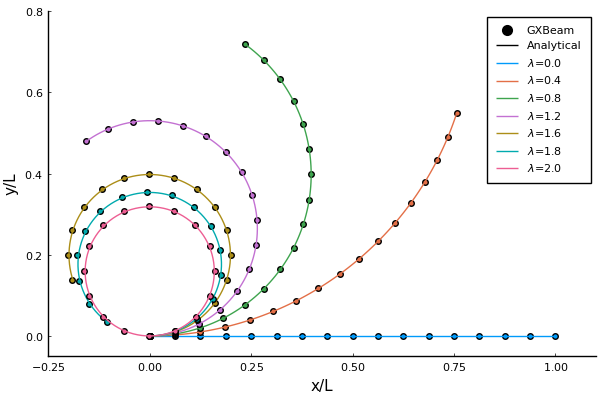

In [4]:
# set up the plot
plot(
    xlim = (-0.25, 1.1),
    xticks = -0.25:0.25:1.0,
    xlabel = "x/L",
    ylim = (-0.05, 0.8),
    yticks = 0.0:0.2:0.8,
    ylabel = "y/L",
    aspect_ratio = 1.0,
    grid = false,
    overwrite_figure=false
    )

# create dummy legend entries for GXBeam and Analytical
scatter!([], [], color=:black, label="GXBeam")
plot!([], [], color=:black, label="Analytical")

# plot the data
for i = 1:length(M)

    local x, y

    # GXBeam
    x = [assembly.points[ipoint][1] + states[i].points[ipoint].u[1] for ipoint =
        1:length(assembly.points)]
    y = [assembly.points[ipoint][2] + states[i].points[ipoint].u[2] for ipoint =
        1:length(assembly.points)]
    scatter!(x/L, y/L, label="", color = i)

    # Analytical
    x0 = range(0, L, length=100)
    deflection = analytical.(x0, E*Iyy/M[i])
    x = (x0 + getindex.(deflection, 1))
    y = getindex.(deflection, 2)
    plot!(x/L, y/L, label="\$\\lambda\$=$(λ[i])", color=i)
end
plot!()

## Grid Convergence Study

We can use this problem to test the accuracy and convergence of this package.  To do so
we set $\lambda = 1$ and repeat the analysis for a variety of grid sizes.  We measure
the normalized tip displacement error $\varepsilon(u)$ using the following expression
$$
\varepsilon(u) = \left| \frac{u - u^a}{u^a} \right|
$$
where $u$ is the calculated tip displacement (at x=L) and $u^a$ is the analytical
tip displacement.

In [5]:
grid_sizes = unique(round.(Int, 10 .^ range(0,3,length=25)))

L = 12 # inches
h = w = 1 # inches
E = 30e6 # lb/in^4 Young's Modulus

A = h*w
Iyy = w*h^3/12
Izz = w^3*h/12

# bending moment (applied at end)
λ = 1.0
m = pi*E*Iyy/L
M = λ*m

# run an analysis for each grid size
states = Vector{AssemblyState{Float64}}(undef, length(grid_sizes))
for (igrid, nelem) in enumerate(grid_sizes)

    local x, y, z, points, start, stop, compliance, assembly, system

    # create points
    x = range(0, L, length=nelem+1)
    y = zero(x)
    z = zero(x)
    points = [[x[i],y[i],z[i]] for i = 1:length(x)]

    # index of endpoints of each beam element
    start = 1:nelem
    stop = 2:nelem+1

    # compliance matrix for each beam element
    compliance = fill(Diagonal([1/(E*A), 0, 0, 0, 1/(E*Iyy), 1/(E*Izz)]), nelem)

    # create assembly of interconnected nonlinear beams
    assembly = Assembly(points, start, stop, compliance=compliance)

    # create dictionary of prescribed conditions
    prescribed_conditions = Dict(
        # fixed left side
        1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0, theta_z=0),
        # moment on right side
        nelem+1 => PrescribedConditions(Mz = M)
    )

    # perform a static analysis
    system, states[igrid], converged = static_analysis(assembly;
        prescribed_conditions = prescribed_conditions)

end

nothing #hide

In [6]:
# calculate analytical solution
dxa, dya = analytical(L, E*Iyy/M)

# extract computational solution
dx = [states[igrid].points[end].u[1] for igrid = 1:length(grid_sizes)]
dy = [states[igrid].points[end].u[2] for igrid = 1:length(grid_sizes)]

# compute error
εx = abs.((dx .- dxa) ./ dxa)
εy = abs.((dy .- dya) ./ dya)

nothing #hide

In [7]:
using Plots
pyplot()
nothing #hide

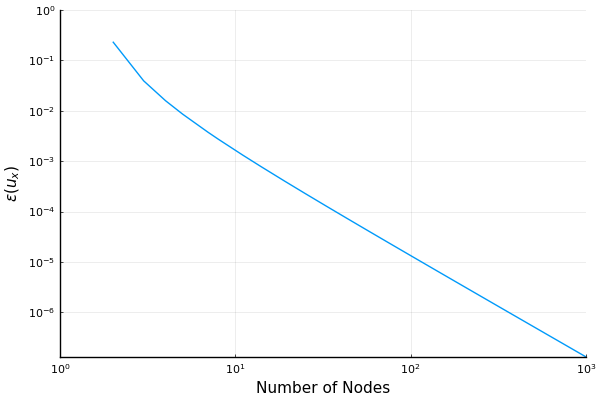

In [8]:
# plot the x-error
p1 = plot(grid_sizes .+ 1, εx, label="",
    xlabel = "Number of Nodes",
    xaxis=:log,
    xlim = (10^0, 10^3),
    xtick = 10.0 .^ (0:3),
    ylabel = "\$\\varepsilon(u_x)\$",
    yaxis=:log,
    ylim = (-Inf, 10^0),
    ytick = 10.0 .^ -(0:7),
    overwrite_figure=false,
    show=true)

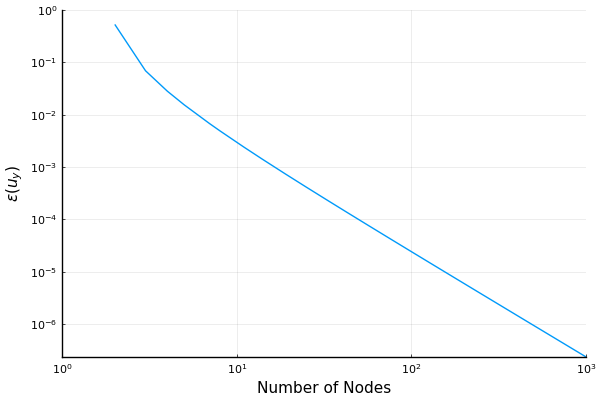

In [9]:
# plot the y-error
p2 = plot(grid_sizes .+ 1, εy, label="",
    xlabel = "Number of Nodes",
    xaxis=:log,
    xlim = (10^0, 10^3),
    xtick = 10.0 .^ (0:3),
    ylabel = "\$\\varepsilon(u_y)\$",
    yaxis=:log,
    ylim = (-Inf, 10^0),
    ytick = 10.0 .^ -(0:7),
    overwrite_figure=false,
    show=true)

We observe second-order algebraic convergence for both x and y tip displacement errors.
We can therefore conclude that a large number of elements are likely necessary in order
to obtain highly accurate solutions using this package.  For problems where high
accuracy solutions are critical, higher order shape functions, such as the Legendre
spectral finite elements used by [BeamDyn](https://www.nrel.gov/wind/nwtc/beamdyn.html)
are likely more computationally efficient.

## Sensitivity Analysis

Suppose we are interested in the sensitivity of tip x and y-displacement with respect to
the nondimensional tip moment $\lambda$ when $\lambda=1$.  As described in the
`sensitivity analysis documentation`, these sensitivities may be
computed using the following code:

In [10]:
using ForwardDiff

# construct pfunc to overwrite prescribed conditions
pfunc = (p, t) -> begin

    # non-dimensional tip moment
    λ = p[1]

    # dimensionalized tip moment
    m = pi*E*Iyy/L
    M = λ*m

    # create dictionary of prescribed conditions
    prescribed_conditions = Dict(
        # fixed left side
        1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0, theta_z=0),
        # moment on right side
        nelem+1 => PrescribedConditions(Mz = M)
    )

    # return named tuple with new arguments
    return (; prescribed_conditions=prescribed_conditions)
end

# construct objective function
objfun = (p) -> begin

    # perform static analysis
    system, state, converged = static_analysis(assembly; pfunc, p)

    # return the desired outputs
    return [state.points[end].u[1], state.points[end].u[2]]
end

# compute sensitivities using ForwardDiff with λ = 1.0
ForwardDiff.jacobian(objfun, [1.0])

2×1 Matrix{Float64}:
 -12.025539968209076
  -7.659921841992032

Note that these sensitivities are the exact sensitivities of the numerical (discretized)
solution rather than the exact sensitivities of the analytic (continuous) solution.  The
former is more appropriate for gradient-based optimization (which operates on the
discretized solution) while the latter better describes the system's actual sensitivities.

For this problem, continuous sensitivities may be derived from the analytic solution as
$\frac{d y}{d \lambda} = -L = -12$ and $\frac{d y}{d \lambda} = \frac{-2 L}{\pi} = \frac{-24}{\pi}$
To obtain continuous sensitivities using GXBeam, a sufficiently fine grid discretization
must be used.  If analytic results are not available, a grid convergence study must be
performed in order to find a sufficiently fine grid discretization.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*